# Chapter 6 - Probability density functions

## Reading

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np

import thinkstats2
import thinkplot

In [3]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [4]:
import brfss

df = brfss.ReadBrfss(nrows=None)

In [5]:
female = df[df.sex==2]
female_heights = female.htm3.dropna()
mean, std = female_heights.mean(), female_heights.std()
mean, std

(163.22347500412215, 7.269156286641344)

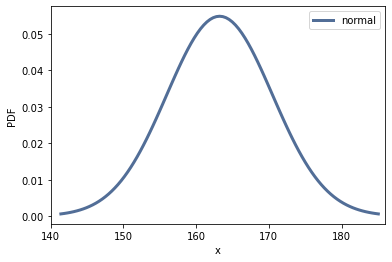

In [6]:
pdf = thinkstats2.NormalPdf(mean, std)
thinkplot.Pdf(pdf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

Make a PMF that approximates the PDF:

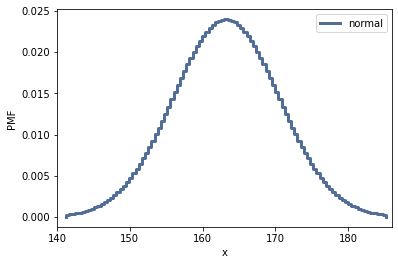

In [7]:
pmf = pdf.MakePmf()
thinkplot.Pmf(pmf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PMF', xlim=[140, 186])

Kernel density estimation:

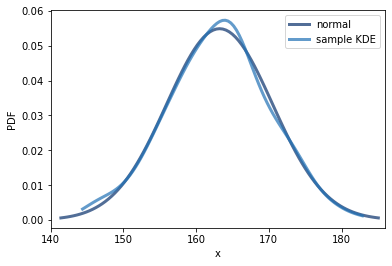

In [11]:
thinkplot.Pdf(pdf, label='normal')

sample = np.random.normal(mean, std, 500)
sample_pdf = thinkstats2.EstimatedPdf(sample, label='sample')
thinkplot.Pdf(sample_pdf, label='sample KDE')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

Moments:

In [12]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

In [13]:
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

The second central moment is the variance.

In [15]:
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

The third standardized moment is skewness, but this measure is not robust to outliers.

Pearson's median skewness is more robust:

In [16]:
def Mean(xs):
    return RawMoment(xs, 1)

def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = Mean(xs)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

In [17]:
PearsonMedianSkewness(female_heights)

0.0922289055190516

In [18]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [19]:
import first

live, firsts, others = first.MakeFrames()

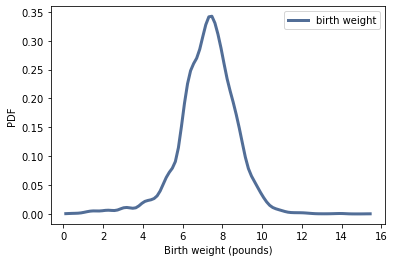

In [20]:
birth_weights = live.totalwgt_lb.dropna()
pdf = thinkstats2.EstimatedPdf(birth_weights)
thinkplot.Pdf(pdf, label='birth weight')
thinkplot.Config(xlabel='Birth weight (pounds)', ylabel='PDF')

In [21]:
PearsonMedianSkewness(birth_weights)

-0.23300028954731833

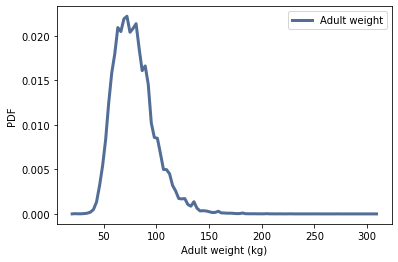

In [22]:
adult_weights = df.wtkg2.dropna()
pdf = thinkstats2.EstimatedPdf(adult_weights)
thinkplot.Pdf(pdf, label='Adult weight')
thinkplot.Config(xlabel='Adult weight (kg)', ylabel='PDF')

In [23]:
PearsonMedianSkewness(adult_weights)

0.2643673381618039

## Exercises

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under $\$5000$.” The highest range includes respondents who made “$\$250,000$ or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [24]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [25]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

In [27]:
import hinc
income_df = hinc.ReadData()

In [28]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

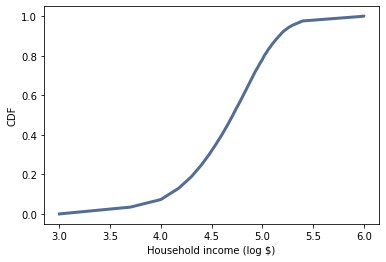

In [29]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [30]:
sample = np.power(10, log_sample)

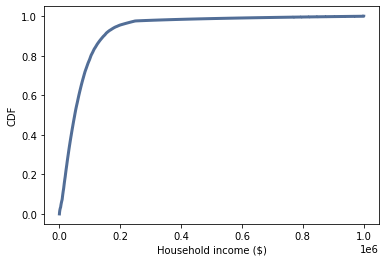

In [31]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [32]:
median = Median(sample)
mean = Mean(sample)
skewness = StandardizedMoment(sample, 3)
pearson_skewness = PearsonMedianSkewness(sample)
print(f'Median: {median}')
print(f'Mean: {mean}')
print(f'Skewness: {skewness}')
print(f"Pearson's skewness: {pearson_skewness}")

Median: 51226.45447894046
Mean: 74278.70753118733
Skewness: 4.949920244429583
Pearson's skewness: 0.7361258019141782


In [33]:
cdf.PercentileRank(mean)

66.0005879566872

66% of respondents report a taxable income below the mean.

What is the upper bound is 10 million?

In [34]:
log_sample = InterpolateSample(income_df, log_upper=7.0)

In [35]:
sample = np.power(10, log_sample)

In [36]:
median = Median(sample)
mean = Mean(sample)
skewness = StandardizedMoment(sample, 3)
pearson_skewness = PearsonMedianSkewness(sample)
print(f'Median: {median}')
print(f'Mean: {mean}')
print(f'Skewness: {skewness}')
print(f"Pearson's skewness: {pearson_skewness}")

Median: 51226.45447894046
Mean: 124267.39722164685
Skewness: 11.603690267537793
Pearson's skewness: 0.39156450927742087


In [37]:
cdf.PercentileRank(mean)

85.65630665207664

The median is the same, but the mean is very different. This affects the two measures of skewness differently - skewness increased but Pearson's skewness decreased.

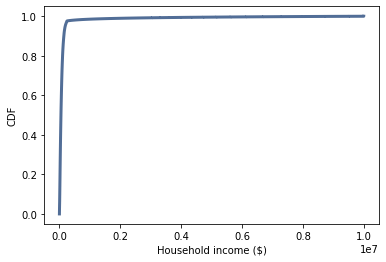

In [38]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')